# COVID-19 Survey Preprocessing and EDA

Let's do some preprocessing and exploratory data analysis (EDA) with the covid-19 data. First, import modules.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

Read data from a .csv file into a dataframe.

In [2]:
filename = '1b_COVID19_daily_survey_ALL_cleaned_deid_2021-07-22_13_26.csv'
df = pd.read_csv(filename)

There are too many columns in the dataframe. Let's pick only the ones that might affect the quality and duration of sleep. Sleeptime, sleep latency and the number of wakes are target variables, since we can take them to be descriptors of sleep quality. The rest are input variables, and we want to investigate how they affect the quality and duration of sleep.

In [3]:
column_names = ['sleepdiary_fallasleep', 'sleepdiary_waketime', 'steps', 'socialize_min', 'leave_house', 'people_contact',
                'alcohol_bev', 'exercise', 'stress', 'worry_scale', 'worry_finances', 'worry_health', 'PHQ9', 
                'covid_status', 'sleepdiary_sleeplatency', 'sleepdiary_wakes']

df = df[column_names]

As a first step, we compute the total sleep time in hours for each row. This is not simple, since the timestamps don't include dates. This leaves room for interpertation and assumptions have to be made. We assume the following: time slept should not be negative or more than 22 hours and the earliest time anyone would go sleep is 15:00. If we don't get a sensible sleep time with these conditions, we set is to NaN.

In [4]:
fallasleep = df['sleepdiary_fallasleep'].tolist()
waketime = df['sleepdiary_waketime'].tolist()
sleeptime = []

def compute_sleeptime(fallasleep, waketime):
    try:
        if int(fallasleep[0:2]) > 15:
            time_i = datetime(2000, 1, 1, int(fallasleep[0:2]), int(fallasleep[3:5]))
        else:
            time_i = datetime(2000, 1, 2, int(fallasleep[0:2]), int(fallasleep[3:5]))
        time_f = datetime(2000, 1, 2, int(waketime[0:2]), int(waketime[3:5]))
    except:
        return np.NaN
    
    delta = time_f - time_i
    delta_hours = delta.total_seconds()/(60**2)

    if delta_hours < 0 or delta_hours > 22:
        return np.NaN
    else:
        return delta_hours

for i in range(len(fallasleep)):
    delta_hours = compute_sleeptime(fallasleep[i], waketime[i])
    sleeptime.append(delta_hours)

# Add sleep time to dataframe
df['sleeptime'] = sleeptime
# Drop unnecessary columns
df = df.drop(['sleepdiary_fallasleep', 'sleepdiary_waketime'], axis = 1)

We also only keep rows with negative Covid status and drop all rows containing NaNs.

In [5]:
# Choose only rows with negative covid status
df = df[df['covid_status'] == 0]
# Drop unecessary column
df = df.drop(['covid_status'], axis = 1)
# Drop rows containing NaNs
df = df.dropna()
df.describe()

,steps,socialize_min,leave_house,people_contact,alcohol_bev,exercise,stress,worry_scale,worry_finances,worry_health,PHQ9,sleepdiary_sleeplatency,sleepdiary_wakes,sleeptime
count,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000,8440.000000
mean,6793.211386,43.910960,0.762441,7.692109,0.739090,0.560664,4.015758,19.163626,3.910308,4.729502,5.594905,16.808264,1.362915,8.050701
std,5723.296630,74.134517,0.425613,237.607487,1.380924,0.496336,1.511221,6.369354,1.713483,1.578662,4.614079,23.701659,1.385320,1.376053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2832.500000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,14.000000,3.000000,3.000000,2.000000,5.000000,0.000000,7.250000
50%,5801.000000,20.000000,1.000000,1.000000,0.000000,1.000000,4.000000,19.000000,4.000000,5.000000,5.000000,10.000000,1.000000,8.000000
75%,9765.000000,60.000000,1.000000,4.000000,1.000000,1.000000,5.000000,24.000000,5.000000,6.000000,8.000000,20.000000,2.000000,8.916667
max,122203.000000,900.000000,1.000000,21772.000000,32.000000,1.000000,7.000000,35.000000,7.000000,7.000000,24.000000,450.000000,5.000000,21.000000


Plot a correlation table, where we can see the correlations between any two variables.

<Axes: >

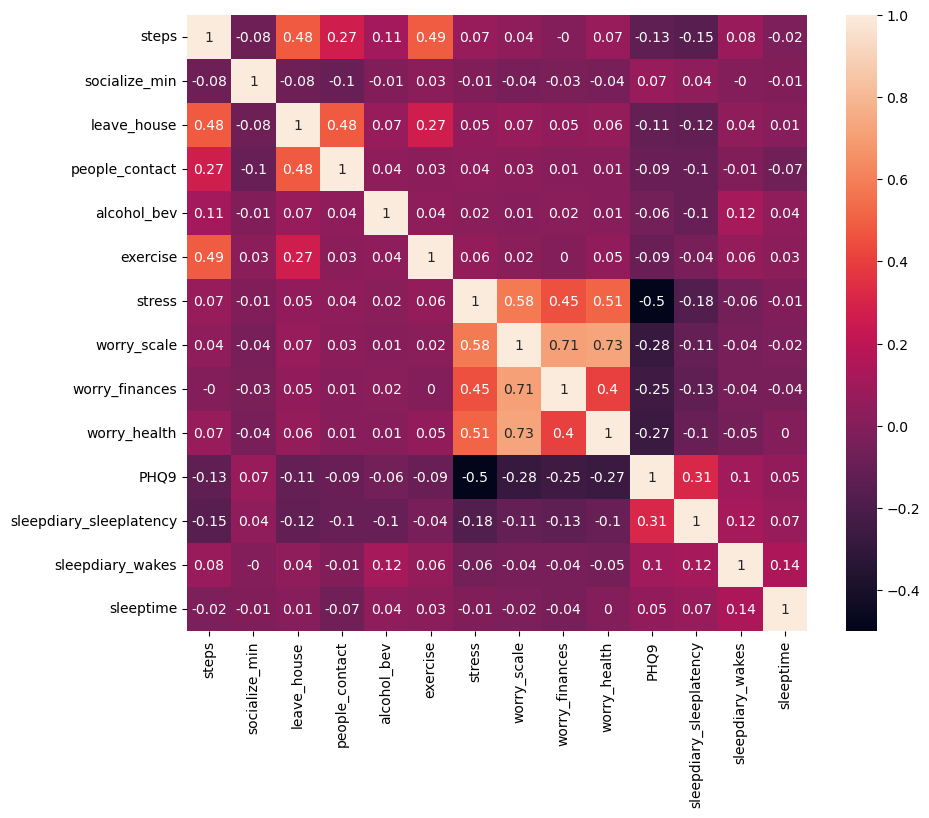

In [6]:
corr = df.corr(method = 'spearman').round(2)
plt.figure(figsize = (10, 8))
sns.heatmap(corr, annot = True)

Plot barplots of the categorical variables to see their distributions.

<Axes: title={'center': 'Number of wakes'}, xlabel='sleepdiary_wakes', ylabel='count'>

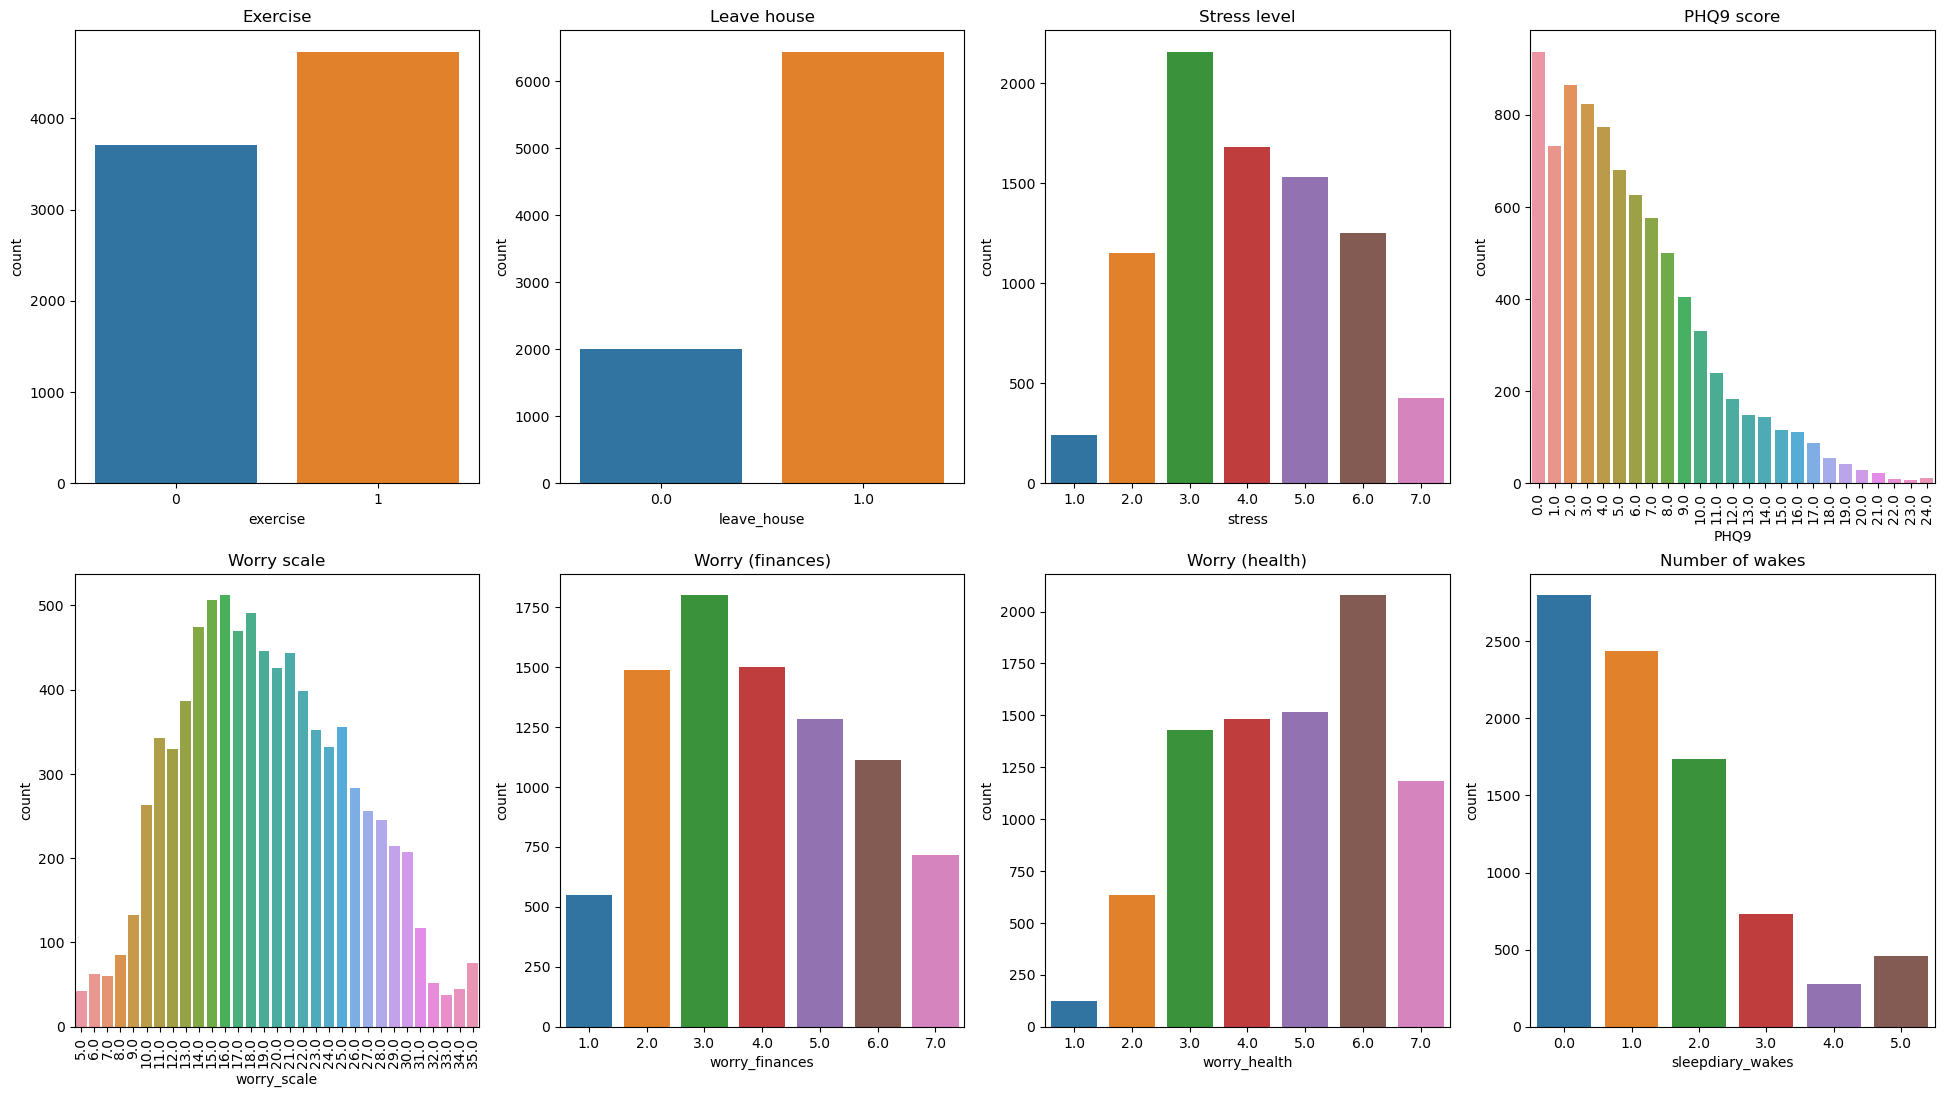

In [7]:
plt.figure(figsize = (24, 20))

rows = 3
columns = 4

plt.subplot(rows, columns, 1)
plt.gca().set_title('Exercise')
sns.countplot(x = 'exercise', data = df)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Leave house')
sns.countplot(x = 'leave_house', data = df)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Stress level')
sns.countplot(x = 'stress', data = df)

plt.subplot(rows, columns, 4)
plt.gca().set_title('PHQ9 score')
plt.xticks(rotation = 90)
sns.countplot(x = 'PHQ9', data = df)

plt.subplot(rows, columns, 5)
plt.gca().set_title('Worry scale')
plt.xticks(rotation = 90)
sns.countplot(x = 'worry_scale', data = df)

plt.subplot(rows, columns, 6)
plt.gca().set_title('Worry (finances)')
sns.countplot(x = 'worry_finances', data = df)

plt.subplot(rows, columns, 7)
plt.gca().set_title('Worry (health)')
sns.countplot(x = 'worry_health', data = df)

plt.subplot(rows, columns, 8)
plt.gca().set_title('Number of wakes')
sns.countplot(x = 'sleepdiary_wakes', data = df)

Similar plots for continious variables.

<Axes: title={'center': 'Sleep time'}, xlabel='sleeptime', ylabel='Count'>

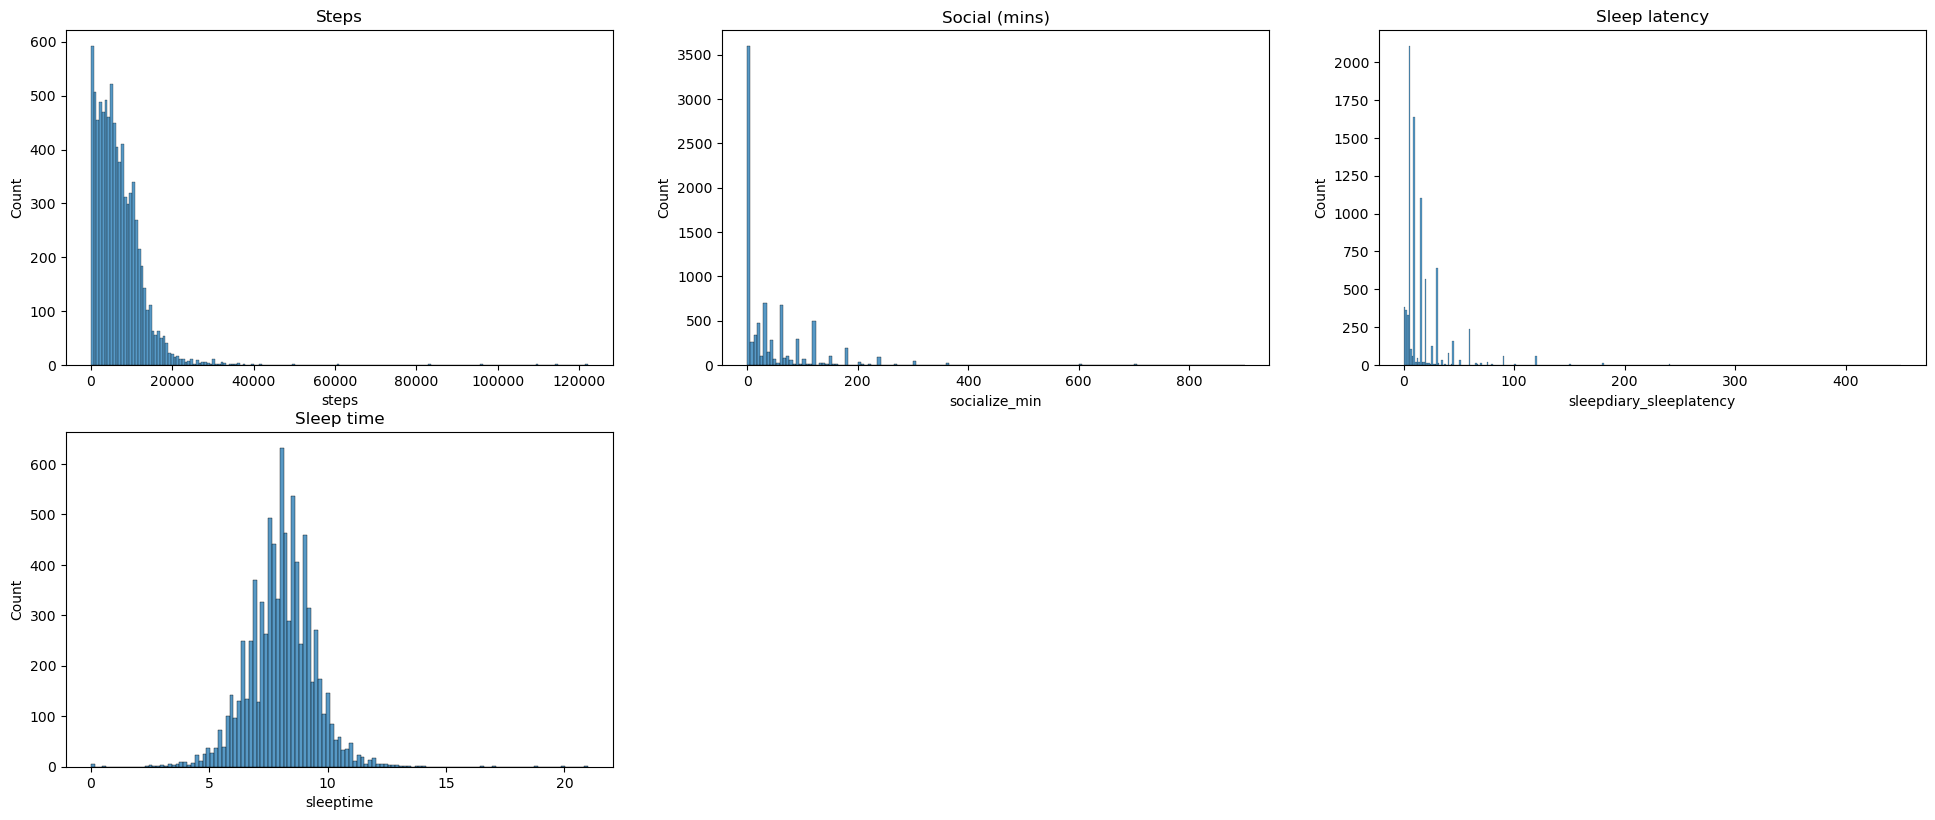

In [8]:
plt.figure(figsize = (24, 20))

rows = 4
columns = 3

plt.subplot(rows, columns, 1)
plt.gca().set_title('Steps')
sns.histplot(x = df['steps'], kde = False)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Social (mins)')
sns.histplot(x = df['socialize_min'], kde = False)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Sleep latency')
sns.histplot(x = df['sleepdiary_sleeplatency'], kde = False)

plt.subplot(rows, columns, 4)
plt.gca().set_title('Sleep time')
sns.histplot(x = df['sleeptime'], kde = False)

Let's plot some scatter plots showing the relations between sleeptime and other variables.

<Axes: title={'center': 'Number of Wakes'}, xlabel='sleepdiary_wakes', ylabel='sleeptime'>

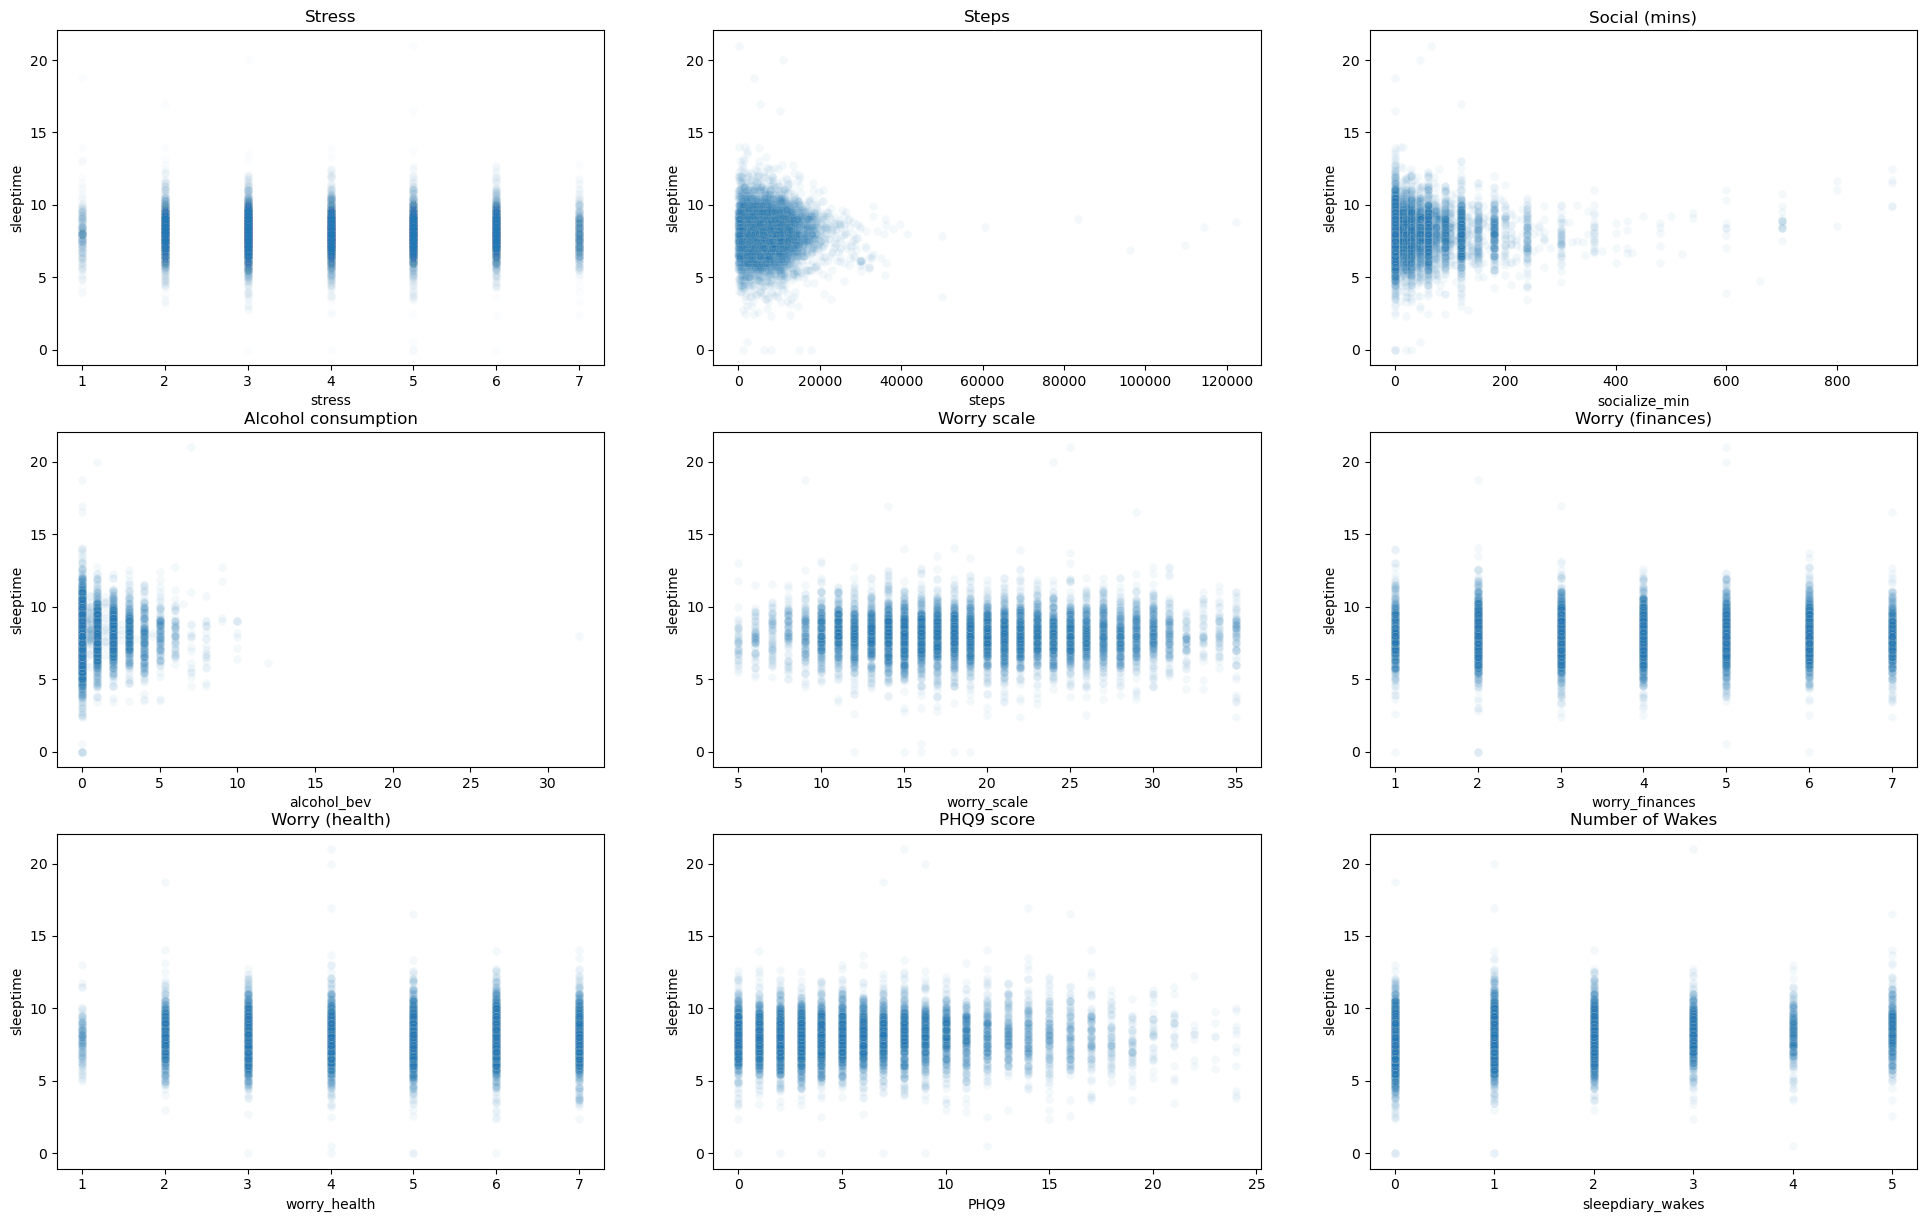

In [9]:
plt.figure(figsize = (24, 20))

rows = 4
columns = 3

plt.subplot(rows, columns, 1)
plt.gca().set_title('Stress')
sns.scatterplot(x = df['stress'], y = df['sleeptime'], alpha = 0.02)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Steps')
sns.scatterplot(x = df['steps'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Social (mins)')
sns.scatterplot(x = df['socialize_min'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 4)
plt.gca().set_title('Alcohol consumption')
sns.scatterplot(x = df['alcohol_bev'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 5)
plt.gca().set_title('Worry scale')
sns.scatterplot(x = df['worry_scale'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 6)
plt.gca().set_title('Worry (finances)')
sns.scatterplot(x = df['worry_finances'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 7)
plt.gca().set_title('Worry (health)')
sns.scatterplot(x = df['worry_health'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 8)
plt.gca().set_title('PHQ9 score')
sns.scatterplot(x = df['PHQ9'], y = df['sleeptime'], alpha = 0.05)

plt.subplot(rows, columns, 9)
plt.gca().set_title('Number of Wakes')
sns.scatterplot(x = df['sleepdiary_wakes'], y = df['sleeptime'], alpha = 0.05)

As an example, let's see how stress affects the number of wakes. In the figure below, the number in each box is the number of rows with the corresponding values of wakes and stress.

<Axes: xlabel='wakes', ylabel='stress'>

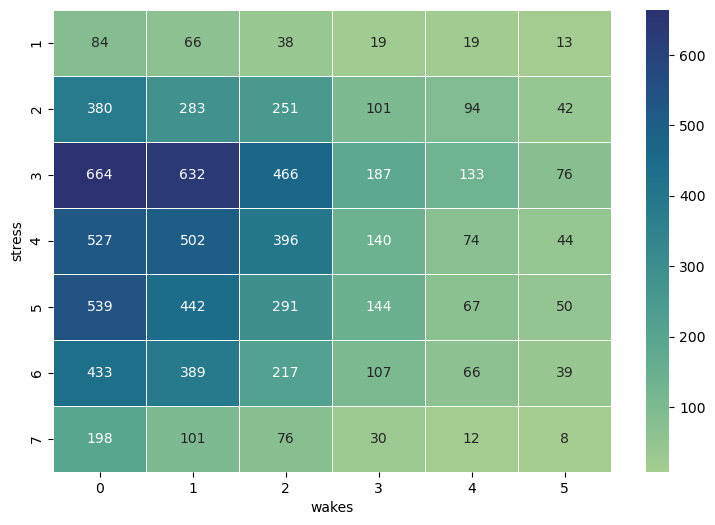

In [10]:
counts_array = []

for stress_level in [1, 2, 3, 4, 5, 6, 7]:
    counts = df[df['stress'] == stress_level]['sleepdiary_wakes'].value_counts().tolist()
    counts_array.append(counts)

df_tmp = pd.DataFrame(counts_array, columns = ['0', '1', '2', '3', '4', '5'])
df_tmp.index = np.arange(1, len(df_tmp) + 1)
df_tmp = df_tmp.rename_axis('stress')
df_tmp = df_tmp.rename_axis('wakes', axis = 1)

f, ax = plt.subplots(figsize = (9, 6))
sns.heatmap(df_tmp, annot = True, fmt = "d", linewidths = 0.5, ax = ax, cmap = 'crest')

Finally, save the preprocessed data to a .csv file.

In [11]:
filename = 'covid_data_preprocessed.csv'

df.to_csv(filename)